## Uncovering value in hospital patient surveys
### Alex Austin
### Data Science with Machine Learning Bootcamp, July 2021
### NYC Data Science Academy
#### Submitted in partial fulfillment of the Python Data Analysis Project

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import itertools

In [2]:
sns.set_theme()
sns.set_context('talk')
sns.set_palette('viridis')

###### For more information on the datasets used in this analysis, see the Readme in the GitHub for this project >> https://github.com/alexdaustin/nycdsa_project1.

In [3]:
# Datatypes for reading in the csv file 'HCAHPS-Hospital.csv'. Since I have
# little use for the date fields I am content to load them as strings.
surveys_dtypes = {'Facility ID':'string',
 'Facility Name':'string',
 'Address':'string',
 'City':'string',
 'State':'string',
 'ZIP Code':'string',
 'County Name':'string',
 'Phone Number':'string',
 'HCAHPS Measure ID':'string',
 'HCAHPS Question':'string',
 'HCAHPS Answer Description':'string',
 'Patient Survey Star Rating':'Int32',
 'Patient Survey Star Rating Footnote':'string',
 'HCAHPS Answer Percent':'Int32',
 'HCAHPS Answer Percent Footnote':'string',
 'HCAHPS Linear Mean Value':'Int32',
 'Number of Completed Surveys':'Int32',
 'Number of Completed Surveys Footnote':'string',
 'Survey Response Rate Percent':'Int32',
 'Survey Response Rate Percent Footnote':'string',
 'Start Date':'string',
 'End Date':'string'}

In [4]:
surveys = pd.read_csv('HCAHPS-Hospital.csv', low_memory = False, 
                      dtype = surveys_dtypes, na_values = ['Not Available', 'Not Applicable'])

In [5]:
# Datatypes for reading in the csv file 'Unplanned_Hospital_Visits-Hospital'. 
# Since I have little use for the date fields I am content to load them as 
# strings. 
unpland_dtypes = {'Facility ID':'string',
 'Facility Name':'string',
 'Address':'string',
 'City':'string',
 'State':'string',
 'ZIP Code':'string',
 'County Name':'string',
 'Phone Number':'string',
 'Measure ID':'string',
 'Measure Name':'string',
 'Compared to National':'string',
 'Denominator':'float',
 'Score':'float',
 'Lower Estimate':'float',
 'Higher Estimate':'float',
 'Number of Patients':'Int32',
 'Number of Patients Returned':'Int32',
 'Footnote':'string',
 'Start Date':'string',
 'End Date':'string'}

In [6]:
unpland = pd.read_csv('Unplanned_Hospital_Visits-Hospital.csv', 
                      low_memory = False, 
                      dtype = unpland_dtypes, na_values = ['Not Available', 'Not Applicable'])

In [7]:
# When reading in the 'FY_2021_HAC_Reduction_Program_Hospital.csv' I switched
# to importing only those columns needed. This made a separate dictionary of
# datatypes unnecessary.
hac = pd.read_csv('FY_2021_HAC_Reduction_Program_Hospital.csv', low_memory = False, usecols = [1, 20, 22], \
                  dtype = {'Facility ID':'string', 'Total HAC Score':'float', 'Payment Reduction':'string'}).set_index('Facility ID')

In [8]:
print(surveys.shape)
print(surveys['Facility ID'].unique().size)
print(surveys['Start Date'].unique().size)
print(surveys['End Date'].unique().size)
print(surveys['Start Date'].unique()[0])
print(surveys['End Date'].unique()[0])

(452538, 22)
4866
1
1
01/01/2019
12/31/2019


###### The above says that there are 4866 hospitals and 93 survey items per hospital for a total of 452,538 rows in the 'surveys' dataframe. Notice that there is a single collection period.

In [9]:
print(unpland.shape)
print(unpland['Facility ID'].unique().size)
print(unpland['Start Date'].unique().size)
print(unpland['End Date'].unique().size)
print(list(unpland['Start Date'].unique()))
print(list(unpland['End Date'].unique()))

(68124, 20)
4866
4
2
['07/01/2017', '01/01/2017', '01/01/2019', '07/01/2019']
['12/01/2019', '12/24/2019']


###### There are again 4866 hospitals, but this time 14 'unplanned visits' measures for each hospital. This results in 68,124 rows. Note the unplanned visits data collection periods can begin in 2017. It is impossible (or at least problematic) to extract only 2019 data because a single measure (single row) can have a start date in 2017 and an end date in 2019. We will continue with the analysis but this is certainly an issue to be aware of and communicated along with the results.

In [10]:
print(hac.shape)

(3204, 2)


###### There is only one row per hospital in the 'hac' dataframe. It is currently not known to the author why there are fewer hospitals in the 'FY_2021_HAC_Reduction_Program_Hospital.csv' dataset. At some point information on dates will be included as it was above for the other two datasets.

In [11]:
list(enumerate(surveys.columns.tolist()))

[(0, 'Facility ID'),
 (1, 'Facility Name'),
 (2, 'Address'),
 (3, 'City'),
 (4, 'State'),
 (5, 'ZIP Code'),
 (6, 'County Name'),
 (7, 'Phone Number'),
 (8, 'HCAHPS Measure ID'),
 (9, 'HCAHPS Question'),
 (10, 'HCAHPS Answer Description'),
 (11, 'Patient Survey Star Rating'),
 (12, 'Patient Survey Star Rating Footnote'),
 (13, 'HCAHPS Answer Percent'),
 (14, 'HCAHPS Answer Percent Footnote'),
 (15, 'HCAHPS Linear Mean Value'),
 (16, 'Number of Completed Surveys'),
 (17, 'Number of Completed Surveys Footnote'),
 (18, 'Survey Response Rate Percent'),
 (19, 'Survey Response Rate Percent Footnote'),
 (20, 'Start Date'),
 (21, 'End Date')]

###### For the most part 'footnotes' in these datasets explain why a value is missing, or give information on a restriction that applies to a measure. They are infrequent, and at this time are deemed unimportant. 

In [12]:
# This uses a regular expression search to extract the star ratings from 'surveys'.
star_ratings = surveys.iloc[:, [0, 8, 11]][surveys['HCAHPS Measure ID'].apply(lambda x: re.search('STAR_RATING$', x) != None)]
star_ratings['HCAHPS Measure ID'] = star_ratings['HCAHPS Measure ID'].apply(lambda x: x[:-12])

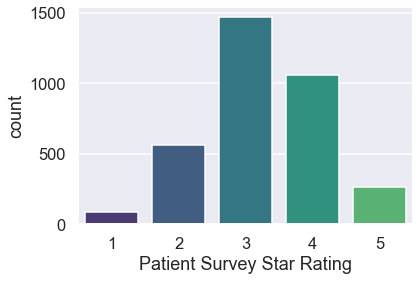

In [13]:
# This shows how hospitals are distributed by overall star rating. Not used
# in the talk slides.
_ = star_ratings[star_ratings['HCAHPS Measure ID']=='H'].dropna()
sns.countplot(x='Patient Survey Star Rating', data=_)
plt.show()

In [14]:
# This extracts the linear scores from 'surveys'.
linear_scores = surveys.iloc[:, [0, 8, 15]][surveys['HCAHPS Measure ID'].apply(lambda x: re.search('LINEAR_SCORE$', x) != None)]
linear_scores['HCAHPS Measure ID'] = linear_scores['HCAHPS Measure ID'].apply(lambda x: x[:-13])

In [15]:
# Join star ratings and linear scores.
star_linear = pd.merge(star_ratings, linear_scores, on=['Facility ID','HCAHPS Measure ID'])

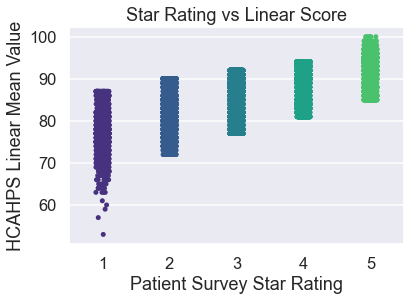

In [16]:
# This shows how linear scores translate to star ratings. This time for all
# measures that have both a star rating and a linear score. Not used in the 
# talk slides.
_ = sns.stripplot(x='Patient Survey Star Rating', y='HCAHPS Linear Mean Value', data=star_linear.dropna())
_.set_title('Star Rating vs Linear Score')
plt.show()

###### Because of the increased amount of information available we will concentrate on linear scores. There is a case to be made for star ratings, but this can be investigated at a future date.

##### We want to get a better feel for our response variables. We first make a useful observation about the 'unplanned visits' data then settled on the 30 day readmission rate as our first target.

In [17]:
list(enumerate(unpland.columns.tolist()))

[(0, 'Facility ID'),
 (1, 'Facility Name'),
 (2, 'Address'),
 (3, 'City'),
 (4, 'State'),
 (5, 'ZIP Code'),
 (6, 'County Name'),
 (7, 'Phone Number'),
 (8, 'Measure ID'),
 (9, 'Measure Name'),
 (10, 'Compared to National'),
 (11, 'Denominator'),
 (12, 'Score'),
 (13, 'Lower Estimate'),
 (14, 'Higher Estimate'),
 (15, 'Number of Patients'),
 (16, 'Number of Patients Returned'),
 (17, 'Footnote'),
 (18, 'Start Date'),
 (19, 'End Date')]

In [18]:
print(list(unpland[unpland['Measure ID']=='READM_30_HOSP_WIDE']['Start Date'].unique()))
print(list(unpland[unpland['Measure ID']=='READM_30_HOSP_WIDE']['End Date'].unique()))

['07/01/2019']
['12/01/2019']


###### It seems by focussing on the measure 'READM_30_HOSP_WIDE' we eliminate the previous concern over dates, though they still do not match precisely so can be considered to only modify the issue. 

In [19]:
# Extract the 30 day readmission rate from 'unpland'.
readm_hw = unpland[unpland['Measure ID']=='READM_30_HOSP_WIDE'].iloc[:, [0, 12]].dropna()
readm_hw = readm_hw.rename(columns={'Score':'READM_RATE'}).set_index('Facility ID')

In [20]:
readm_hw.shape

(4131, 1)

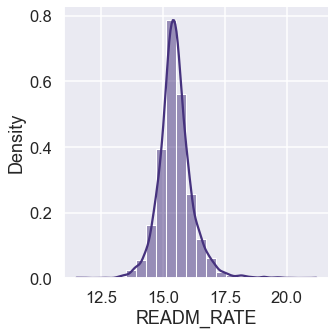

In [21]:
# This shows the distribution of the 30 day readmission rate. Out first
# response variable. Not used in the talk.
sns.displot(x=readm_hw['READM_RATE'], kde=True, stat='density', bins=24)

##### Our second target is the total Hac score from the hac dataframe.

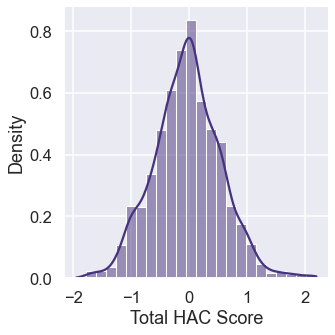

In [22]:
# This shows the distribution of the total HAC score. Our second
# response variable. Not used in the talk.
sns.displot(x=hac['Total HAC Score'], kde=True, stat='density', bins=24)

In [23]:
# Join the readmission rates and the HAC scores.
readm_hac = pd.merge(readm_hw, hac, on='Facility ID').drop(columns='Payment Reduction').dropna()
readm_hac

,READM_RATE,Total HAC Score
Facility ID,,
010001,15.5,-0.3958
010005,14.7,0.5547
010006,15.7,-0.0853
010007,15.7,-0.7965
010008,15.3,0.0247
...,...,...
670112,14.5,-0.0149
670116,15.9,-0.3018
670120,16.5,-0.6383


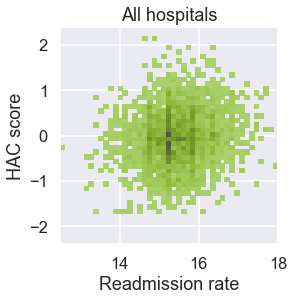

In [24]:
# This plots the bivariate density of readmission rates and HAC scores.
_ = sns.histplot(data=readm_hac, x='READM_RATE', y='Total HAC Score', color='olivedrab')
_.set_xlim(left=12.5, right=18)
_.set_ylim(bottom=-2.4, top=2.4)
_.set_title('All hospitals')
_.set_xlabel('Readmission rate')
_.set_ylabel('HAC score')
_.axes.set_box_aspect(1)
plt.savefig('2_target_dist', bbox_inches='tight')
plt.show()

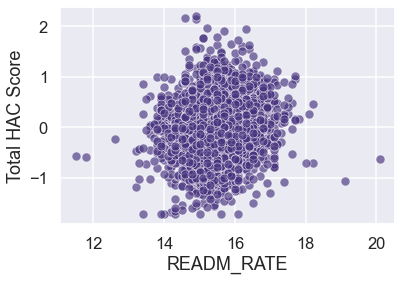

In [25]:
# Essentially the same thing but as a scatter plot. Not used in the talk.
sns.scatterplot(data=readm_hac, x='READM_RATE', y='Total HAC Score', alpha=0.65)
plt.show()

#### We now focus on readmission rates for a time.

In [26]:
# We create an unstacked dataframe from linear_scores convenient for some
# later analysis.
linear_scores = linear_scores.set_index(['Facility ID', 'HCAHPS Measure ID'])
linear_pv = linear_scores.unstack().droplevel(0, axis = 1)
linear_pv

HCAHPS Measure ID,H_CLEAN,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_QUIET,H_RECMND
Facility ID,,,,,,,,,,
010001,87,90,91,84,80,90,82,88,86,90
010005,85,91,93,83,80,90,81,88,85,88
010006,86,90,92,78,76,84,80,86,87,87
010007,88,91,92,86,83,90,83,88,88,88
010008,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
670260,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
670266,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
670267,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [27]:
# In case a person were concerned about the number of missing values.
linear_pv.dropna().shape

(3445, 10)

In [28]:
# Join the unstacked survey scores and the readmission rates.
lin_readm = pd.merge(linear_pv, readm_hw, on='Facility ID')
lin_readm

,H_CLEAN,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_QUIET,H_RECMND,READM_RATE
Facility ID,,,,,,,,,,,
010001,87,90,91,84,80,90,82,88,86,90,15.5
010005,85,91,93,83,80,90,81,88,85,88,14.7
010006,86,90,92,78,76,84,80,86,87,87,15.7
010007,88,91,92,86,83,90,83,88,88,88,15.7
010008,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,15.3
...,...,...,...,...,...,...,...,...,...,...,...
670116,93,95,94,92,86,91,86,93,92,94,15.9
670120,89,89,89,83,78,84,80,87,85,87,16.5
670122,86,91,91,85,77,86,82,92,84,92,16.9


###### The following three functions together perform a best subsets linear regression. Here best is determined by maximum R^2-adjusted.

In [29]:
# Performs linear regression on a subset of predictors (columns).
def reg_on_subset(ary_y, df_X, subset):
    X = np.array(df_X[list(subset)]).astype(float)
    X = sm.add_constant(X)
    model = sm.OLS(ary_y, X)
    
    return model.fit()  

In [30]:
# Finds the best linear regression over the subsets of size k.

def best_reg(ary_y, df_X, k):
    R2 = 0
    for subset in itertools.combinations(df_X.columns, k):
        fit = reg_on_subset(ary_y, df_X, subset)
        if fit.rsquared_adj > R2:
            best_yet = fit
            R2 = fit.rsquared_adj
    
    return best_yet   

In [31]:
# Finds the best linear regression over all subset size levels.

def best_subset(ary_y, df_X):
    R2 = 0
    n = len(df_X.columns)
    for k in range(1,n+1):
        fit = best_reg(ary_y, df_X, k)
        if fit.rsquared_adj > R2:
            best_yet = fit
            R2 = fit.rsquared_adj
            
    return best_yet

In [32]:
list(enumerate(lin_readm.columns.tolist()))

[(0, 'H_CLEAN'),
 (1, 'H_COMP_1'),
 (2, 'H_COMP_2'),
 (3, 'H_COMP_3'),
 (4, 'H_COMP_5'),
 (5, 'H_COMP_6'),
 (6, 'H_COMP_7'),
 (7, 'H_HSP_RATING'),
 (8, 'H_QUIET'),
 (9, 'H_RECMND'),
 (10, 'READM_RATE')]

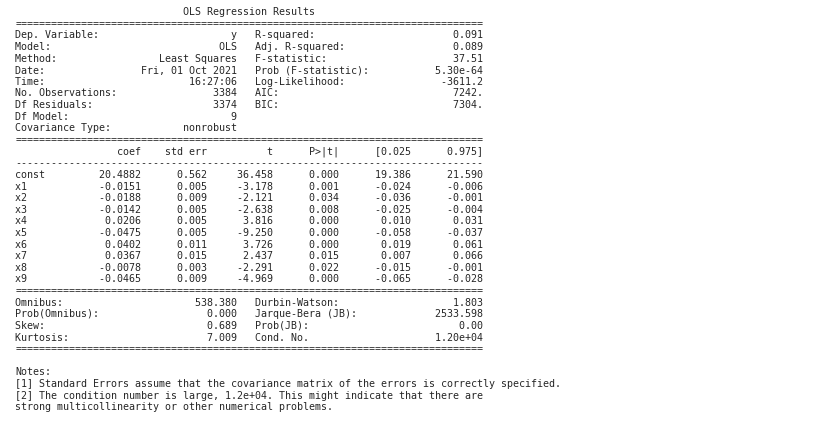

In [33]:
# Perform best subsets linear regression with linear scores as predictors and
# readmission rate as response. Output the results summary as a png.
X = lin_readm.dropna().iloc[:, range(10)]
y = np.array(lin_readm.dropna()['READM_RATE']).astype(float)
readm_best = best_subset(y, X)

plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(readm_best.summary()), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('readm_best', bbox_inches='tight')

In [34]:
# Correlations of the various linear scores with readmission rate.
readm_corr = lin_readm.corr()[:-1]['READM_RATE'].sort_values()
readm_corr

H_COMP_6       -0.262240
H_RECMND       -0.232840
H_COMP_1       -0.226153
H_HSP_RATING   -0.225432
H_COMP_3       -0.212882
H_COMP_7       -0.203613
H_COMP_2       -0.197653
H_CLEAN        -0.193883
H_COMP_5       -0.167898
H_QUIET        -0.157066
Name: READM_RATE, dtype: float64

In [35]:
#Creating a dataframe for a facet grid.
lin_for_facet = linear_scores.reset_index().set_index('Facility ID')

In [36]:
Measure_ID_dict = { \
    'H_CLEAN':'Cleanliness', \
    'H_COMP_1':'Nurse communication', \
    'H_COMP_2':'Doctor communication', \
    'H_COMP_3':'Staff responsiveness', \
    'H_COMP_5':'Communication about medicine', \
    'H_COMP_6':'Discharge information', \
    'H_COMP_7':'Care transition', \
    'H_HSP_RATING':'Overall hospital rating', \
    'H_QUIET':'Quietness', \
    'H_RECMND':'Recommend hospital' \
}

In [37]:
# This will give the different measures descriptive names for use in a chart.
def replace_pred(meas):
    return Measure_ID_dict[meas]

In [38]:
# Further preliminaries to creation of the facet grid.
readm_facet_data = pd.merge(lin_for_facet, readm_hw, on='Facility ID').dropna()\
    .rename(columns={'HCAHPS Measure ID':'Predictor', 'HCAHPS Linear Mean Value':'Linear score', 'READM_RATE':'Readmission rate'})
readm_facet_data = readm_facet_data[readm_facet_data['Predictor'].isin(['H_COMP_6', 'H_COMP_1', 'H_COMP_3', 'H_COMP_7'])]
readm_facet_data['Predictor'] = readm_facet_data['Predictor'].apply(lambda x: replace_pred(x))
readm_facet_data['Linear score'] = readm_facet_data['Linear score'].astype('float64')

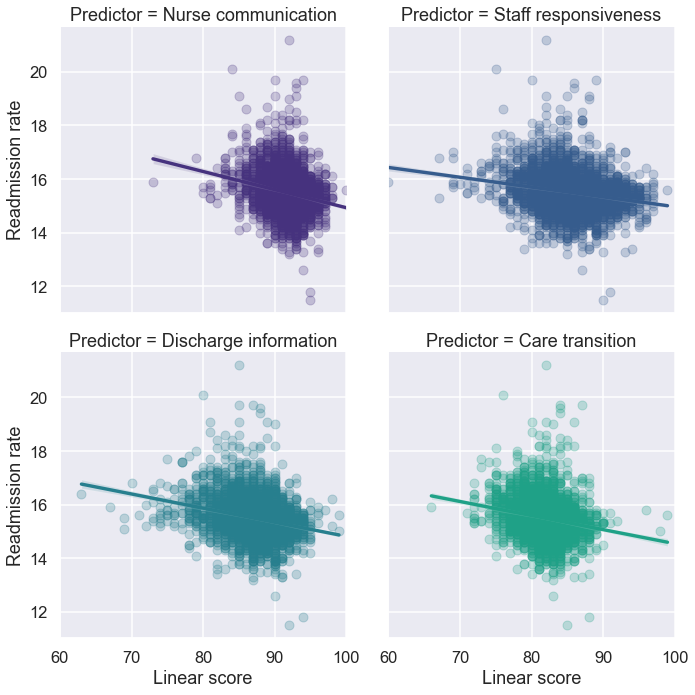

In [39]:
# Facet grid for simple regressions corresponding to 'Discharge information',
# 'Nurse communication', 'Staff responsiveness', and 'Care transition'.
_ = sns.lmplot(x='Linear score', y='Readmission rate', col='Predictor', \
    hue='Predictor', data=readm_facet_data, col_wrap=2, scatter_kws={'alpha':0.25})
_.tight_layout()
_.savefig('readm_facet')

In [40]:
# This prints out results summaries for the regressions in the above grid.
for pred in readm_facet_data['Predictor'].unique():
    X = np.array(readm_facet_data[readm_facet_data['Predictor']==pred]['Linear score'])
    X = sm.add_constant(X)
    y = np.array(readm_facet_data[readm_facet_data['Predictor']==pred]['Readmission rate'])
    model = sm.OLS(y, X)
    reg = model.fit()
    print(reg.summary())
    print('\n')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     182.3
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           1.68e-40
Time:                        16:27:09   Log-Likelihood:                -3683.8
No. Observations:                3384   AIC:                             7372.
Df Residuals:                    3382   BIC:                             7384.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6824      0.458     47.321      0.0

#### Our focus now moves on to HAC scores.

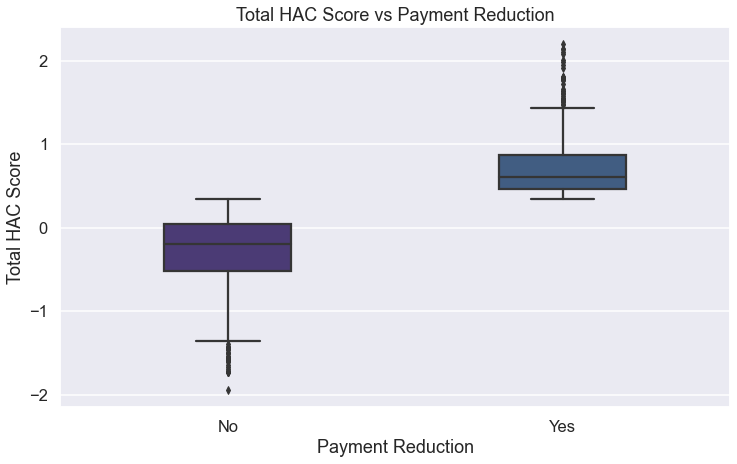

In [41]:
# Total HAC score is used to decide whether a hospital is subject to a
# reduction in Medicare funding. This shows the distribution of those that
# were subject to a reduction and those that were not. Roughly speaking those
# with a score above the 75-th percentile are subject to a reduction.
# Not used in the talk.
_ = sns.boxplot(x='Payment Reduction', y='Total HAC Score', data=hac, width=0.38)
_.set_title('Total HAC Score vs Payment Reduction')
plt.show()

In [42]:
# Join linear scores and HAC scores.
lin_hac = pd.merge(linear_pv, hac, on='Facility ID').drop(columns='Payment Reduction')
lin_hac

,H_CLEAN,H_COMP_1,H_COMP_2,H_COMP_3,H_COMP_5,H_COMP_6,H_COMP_7,H_HSP_RATING,H_QUIET,H_RECMND,Total HAC Score
Facility ID,,,,,,,,,,,
010001,87,90,91,84,80,90,82,88,86,90,-0.3958
010005,85,91,93,83,80,90,81,88,85,88,0.5547
010006,86,90,92,78,76,84,80,86,87,87,-0.0853
010007,88,91,92,86,83,90,83,88,88,88,-0.7965
010008,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0247
...,...,...,...,...,...,...,...,...,...,...,...
670133,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
670134,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
670135,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN


In [43]:
# Best subsets regression with linear scores as predictors and HAC score as 
# response. We do not export as png because this was not used in the talk.
X = lin_hac.dropna().iloc[:, range(10)]
y = np.array(lin_hac.dropna()['Total HAC Score']).astype(float)
hac_best = best_subset(y, X)
print(hac_best.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     40.47
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           2.40e-40
Time:                        16:27:12   Log-Likelihood:                -2344.0
No. Observations:                2883   AIC:                             4700.
Df Residuals:                    2877   BIC:                             4736.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6775      0.454      5.892      0.0

In [44]:
# Correlations of the various linear scores with HAC score.
hac_corr = lin_hac.corr()[:-1]['Total HAC Score'].sort_values()
hac_corr

H_COMP_3       -0.227254
H_CLEAN        -0.211575
H_QUIET        -0.202352
H_COMP_5       -0.191847
H_COMP_7       -0.180225
H_COMP_1       -0.179704
H_HSP_RATING   -0.173021
H_COMP_2       -0.165452
H_COMP_6       -0.143240
H_RECMND       -0.138713
Name: Total HAC Score, dtype: float64

In [45]:
# Simple regression with 'Staff responsiveness' as predictor.
hac_C3_X_ = np.array(lin_hac[['H_COMP_3', 'Total HAC Score']].dropna()['H_COMP_3']).astype('float')
hac_C3_X = sm.add_constant(hac_C3_X_)
hac_C3_y = np.array(lin_hac[['H_COMP_3', 'Total HAC Score']].dropna()['Total HAC Score']).astype('float')
hac_C3_m = sm.OLS(hac_C3_y, hac_C3_X)
hac_C3_reg = hac_C3_m.fit()
print(hac_C3_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     156.9
Date:                Fri, 01 Oct 2021   Prob (F-statistic):           4.36e-35
Time:                        16:27:12   Log-Likelihood:                -2365.6
No. Observations:                2883   AIC:                             4735.
Df Residuals:                    2881   BIC:                             4747.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6586      0.215     12.340      0.0

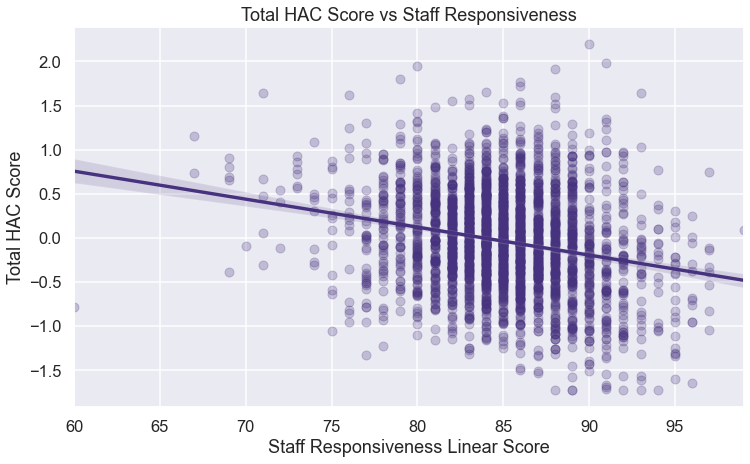

In [46]:
# Plot of the previous regression. We do not construct a facet grid as 
# there was no time for inclusion in the talk.
_ = sns.regplot(x = hac_C3_X_, y = hac_C3_y, scatter_kws={'alpha':0.25})
_.set_title('Total HAC Score vs Staff Responsiveness')
_.set_xlabel('Staff Responsiveness Linear Score')
_.set_ylabel('Total HAC Score')
plt.show()